<a href="https://colab.research.google.com/github/TMhdSofyan/KAUST-Hackathon-EnergyHarvest/blob/main/08_UpdateNeuralNetwork_EarlyStopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
! pip install jcopml

In [6]:
! pip install jcopdl==1.1.10

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for jcopdl: filename=jcopdl-1.1.10-py2.py3-none-any.whl size=17913 sha256=785e63e73dd46e0b1ad522625b938cc72344c7bcc7d0ef0bdd94442f44a3bcf7
  Stored in directory: /root/.cache/pip/wheels/41/95/30/86345d2446be19c7d97dee789a2597bee81cfbb7b24a847f7c
Successfully built jcopdl


In [ ]:
! pip install luwiji

In [132]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [133]:
df = pd.read_csv('/content/drive/MyDrive/00_History_Matching/Data/03_Training_df2.csv')

In [134]:
df.head()

case_num  days     years  oil_prod_rate  oil_prod_cum  water_inj_rate  \
0         0     0  0.000000            0.0             0            0.00   
1         0    31  0.084932        26614.0        825035         1740.71   
2         0    62  0.169863        21427.7       1489290         1740.71   
3         0    93  0.254795        18809.7       2072390         1740.71   
4         0   124  0.339726        16676.6       2589370         1740.71   

   water_inj_cum category      Kh_Kv     inj_rate  permeability  porosity  \
0            0.0    train  16.423475  1740.711355    288.983333  0.163009   
1        53962.1    train  16.423475  1740.711355    288.983333  0.163009   
2       107924.0    train  16.423475  1740.711355    288.983333  0.163009   
3       161886.0    train  16.423475  1740.711355    288.983333  0.163009   
4       215848.0    train  16.423475  1740.711355    288.983333  0.163009   

     prod_bhp  thickness  
0  796.992254  23.718632  
1  796.992254  23.718632  
2  796.992254  23.718632  
3  796.992254  23.718632  
4  796.992254  23.718632

In [89]:
df['oil_prod_cum_10e5'] = df['oil_prod_cum'] / 100000

In [135]:
df.set_index('case_num', inplace=True)

In [153]:
X = df.drop(columns=["oil_prod_rate", 'days', 'oil_prod_cum', 'water_inj_rate', 'water_inj_cum', 'category']) #'oil_prod_cum_10e5'])
y = df.oil_prod_cum.values #For convert this value from DataFrame to Array

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((62250, 7), (20750, 7), (62250,), (20750,))

#Sample Data

In [140]:
X.head() #X data is still in DataFrame format

years      Kh_Kv     inj_rate  permeability  porosity  \
case_num                                                             
0         0.000000  16.423475  1740.711355    288.983333  0.163009   
0         0.084932  16.423475  1740.711355    288.983333  0.163009   
0         0.169863  16.423475  1740.711355    288.983333  0.163009   
0         0.254795  16.423475  1740.711355    288.983333  0.163009   
0         0.339726  16.423475  1740.711355    288.983333  0.163009   

            prod_bhp  thickness  
case_num                         
0         796.992254  23.718632  
0         796.992254  23.718632  
0         796.992254  23.718632  
0         796.992254  23.718632  
0         796.992254  23.718632

In [154]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling = 'minmax'), X_train.columns)
])

In [155]:
X_train = preprocessor.fit_transform(X_train)

X_test = preprocessor.transform(X_test)

In [174]:
#This step can be skipped if we have performed the two step above

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [156]:
X_test #now the data is converted into array

array([[0.86585366, 0.42929159, 0.45736772, ..., 0.36476816, 0.03394233,
        0.28014027],
       [0.7195122 , 0.68405732, 0.13581192, ..., 0.33369475, 0.83021944,
        0.19458952],
       [0.73170732, 0.17392881, 0.80192581, ..., 0.99863143, 0.91964938,
        0.38292844],
       ...,
       [0.41463415, 0.99095938, 0.06718725, ..., 0.84289387, 0.1354171 ,
        0.98267889],
       [0.75609756, 0.95605147, 0.81690739, ..., 0.39171178, 0.84651594,
        0.43011364],
       [0.01219512, 0.6784207 , 0.95270484, ..., 0.06628771, 0.99480689,
        0.25200097]])

---------------------------------------------

#STEP 1: DATASET & DATALOADER
Data loader --> aims to create the mini batch

In [32]:
import torch
from torch. utils.data import DataLoader, TensorDataset

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [200]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [201]:
# Create dataset (train & test) with the tensor data above and also create dataloader 
train_set = TensorDataset (X_train, y_train)
trainloader = DataLoader(train_set, batch_size=64, shuffle=True)

test_set = TensorDataset(X_test, y_test)
testloader = DataLoader(test_set, batch_size=64)

In [98]:
train_set[:5]

(tensor([[0.2805, 0.7662, 0.2506, 0.1330, 0.3310, 0.7402, 0.5776],
         [0.8293, 0.3292, 0.5925, 0.6938, 0.1274, 0.0145, 0.0802],
         [0.2561, 0.8989, 0.7840, 0.9963, 0.6384, 0.4654, 0.7463],
         [0.6585, 0.0957, 0.8624, 0.8319, 0.7530, 0.2110, 0.7686],
         [0.8902, 0.1976, 0.6626, 0.7750, 0.9389, 0.6230, 0.6626]]),
 tensor([117.1780,  83.3404, 294.6890, 387.2940, 367.1870]))

-----------------------------------------------------------

#**Step 2 : Architecture and Configuration**

In [59]:
#import neural network
from torch import nn

In [202]:
from jcopdl.layers import linear_block
class NN(nn.Module):
    def __init__(self, input_size, n1, output_size, dropout = 0.3):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            linear_block(input_size, n1, dropout = dropout),
            linear_block(n1, output_size)
        )
        
    def forward(self, x):
        return self.fc(x)

In [203]:
from jcopdl.callback import Callback, set_config

In [204]:
config = set_config({
    "input_size": 7,
    "n1": 4,
    "output_size": 1,
    "dropout": 0.3
})

____

#**Step 3: Training Preparation**
Prepare model, criterion, and optimizer

##Model

In [ ]:
help(Callback)

In [205]:
from torch import optim


model = NN(config.input_size, config.n1, config.output_size, config.dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.005 )
callback = Callback(model, config, early_stop_patience=7, outdir = 'model')

-------------------

#**Step 4: Training Loop**

In [206]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):   #feature = X , Target = y
        feature, target = feature.to(device), target.to(device)
        output = model(feature) # model 
        loss = criterion(output, target) #criterion output vs target
        
        if mode == "train":
            loss.backward() #backpropagation
            optimizer.step() #update weigh
            optimizer.zero_grad() #reset optimizer to 0
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 391183168575328.0625 | Test_cost  = 386505830646083.7500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 391137345544451.7500 | Test_cost  = 386443519596906.2500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 391062359198355.2500 | Test_cost  = 386359190494910.6250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 390970379924113.6250 | Test_cost  = 386261389147781.0000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 390866495869439.0000 | Test_cost  = 386154631215568.0625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 390755861055457.6875 | Test_cost  = 386041688498107.3125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 390639014598668.1875 | Test_cost  = 385924784714716.1875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 390518526919489.2500 | Test_cost  = 385805112352715.1250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 390399331035812.8750 | Test_cost  = 385684529580545.4375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 390276714125518.9375 | Test_cost  = 385562898603495.8750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 390153623372742.4375 | Test_cost  = 385441377484465.1875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 390031942970149.3125 | Test_cost  = 385320832429094.1875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 389913208825642.7500 | Test_cost  = 385201884428851.5625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 389791574571308.8750 | Test_cost  = 385084192913529.3750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 389672989438665.9375 | Test_cost  = 384968630841698.9375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 389557705402362.6875 | Test_cost  = 384855533123784.3750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 389445890789757.0000 | Test_cost  = 384744947198475.6875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 389334626644480.8125 | Test_cost  = 384637531418282.5000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 389221714633233.3125 | Test_cost  = 384532102577929.6250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 389122217752894.8125 | Test_cost  = 384430772145435.7500 | 


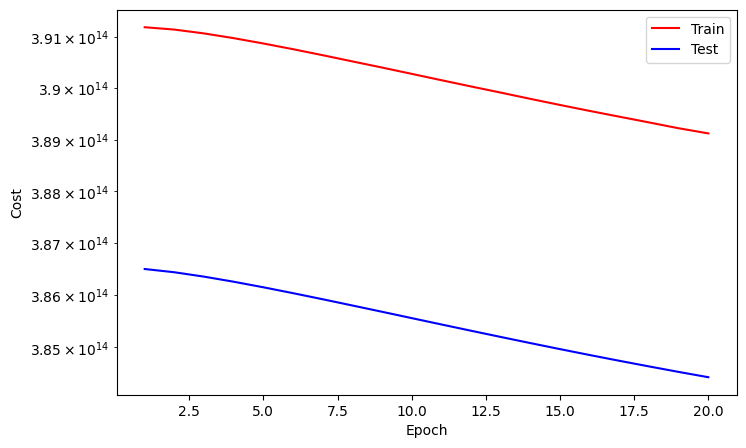

Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 389023744280037.1875 | Test_cost  = 384332259327917.8750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 388921816979689.8125 | Test_cost  = 384236341162239.4375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 388830976737459.0000 | Test_cost  = 384144310278316.7500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 388747021705122.5625 | Test_cost  = 384056149974936.5625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 388653842683944.6250 | Test_cost  = 383970057601284.5625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 388571714800122.5625 | Test_cost  = 383887282093746.8125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 388483734334483.2500 | Test_cost  = 383806933896032.0000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 388413005122454.2500 | Test_cost  = 383730954727925.8125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 388346183823979.1875 | Test_cost  = 383658139184864.1875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 388263743899571.3750 | Test_cost  = 383586892372139.1250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 388189834209278.8750 | Test_cost  = 383519039463270.0000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 388121909489074.0625 | Test_cost  = 383453394083502.8750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 388049815952222.8125 | Test_cost  = 383390470820372.5625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 387998138007698.3125 | Test_cost  = 383331014514352.2500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 387936295688871.1250 | Test_cost  = 383273495652555.1250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 387871135277104.1875 | Test_cost  = 383218475180996.0625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 387835462376202.6250 | Test_cost  = 383166935340584.4375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 387767520498767.6875 | Test_cost  = 383116243814428.6250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 387723660294897.0625 | Test_cost  = 383068109410895.0000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 387675279596981.3125 | Test_cost  = 383022284043875.6250 | 


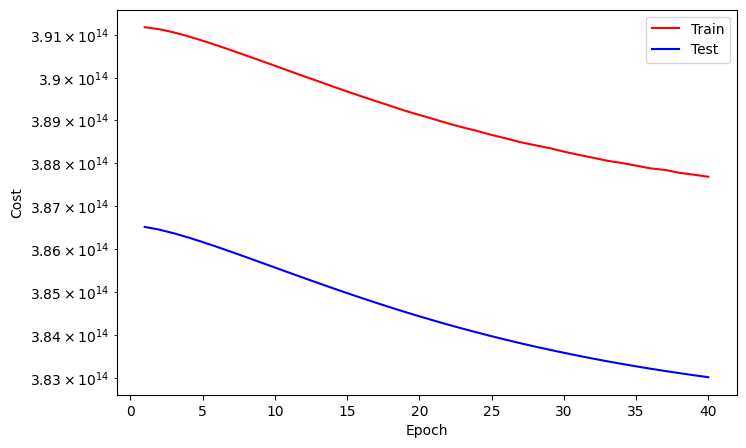

Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 387635147664051.6250 | Test_cost  = 382978664485383.9375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 387585478117494.1250 | Test_cost  = 382936605791746.5000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 387548394545688.1250 | Test_cost  = 382896960501034.9375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 387511090177095.1875 | Test_cost  = 382859412467433.6875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 387467344452861.1250 | Test_cost  = 382822613051806.7500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 387430240071917.0000 | Test_cost  = 382788057627225.5000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 387394504746296.2500 | Test_cost  = 382754990803380.0625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 387366053766063.5625 | Test_cost  = 382723659016955.7500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 387343961629371.8125 | Test_cost  = 382694296537719.8750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 387305907451554.8125 | Test_cost  = 382665662391793.5625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 387282838629166.2500 | Test_cost  = 382638132582864.8750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 387239113004171.7500 | Test_cost  = 382611017089508.8125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 387216176313476.6250 | Test_cost  = 382586321713199.1875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 387198701125403.0000 | Test_cost  = 382562944717204.6875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 387193104336701.9375 | Test_cost  = 382542045374000.6875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 387152419542084.6875 | Test_cost  = 382519529945858.4375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 387142681971532.5625 | Test_cost  = 382499855062901.6250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 387115483023857.1250 | Test_cost  = 382480512464229.3750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 387098524691544.1875 | Test_cost  = 382461760145422.4375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 387075791473846.6875 | Test_cost  = 382443972570707.6250 | 


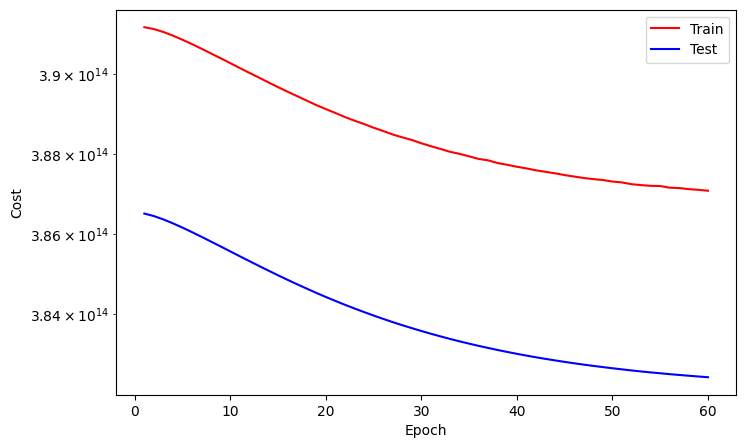

Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 387047669817562.1875 | Test_cost  = 382426513910280.5625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 387055663813583.2500 | Test_cost  = 382412037496618.0000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 387029239770073.8750 | Test_cost  = 382396504411039.1875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 387024700390678.1250 | Test_cost  = 382382838148519.5000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 386998871953698.9375 | Test_cost  = 382368170938696.8750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 386993725245013.3125 | Test_cost  = 382355115298922.1875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 386979906878771.0625 | Test_cost  = 382343010949125.3125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 386966997329333.5625 | Test_cost  = 382331050112038.3750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 386948119855459.8125 | Test_cost  = 382318825315575.8125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 386944637919328.0625 | Test_cost  = 382308196151210.3125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 386928551712250.6250 | Test_cost  = 382298312351252.0625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 386918276893467.5625 | Test_cost  = 382288988844007.9375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 386915226416662.8125 | Test_cost  = 382279595692316.6250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 386896457914108.5625 | Test_cost  = 382270557367019.9375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 386880434225541.0000 | Test_cost  = 382261733246748.8125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    76
Train_cost  = 386888738460719.6250 | Test_cost  = 382254317843409.1250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    77
Train_cost  = 386870243792516.0000 | Test_cost  = 382246394818919.6875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    78
Train_cost  = 386854867876435.6875 | Test_cost  = 382239053290311.1250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    79
Train_cost  = 386857829760915.5625 | Test_cost  = 382232675884835.6875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    80
Train_cost  = 386846613131483.8750 | Test_cost  = 382226047579531.3125 | 


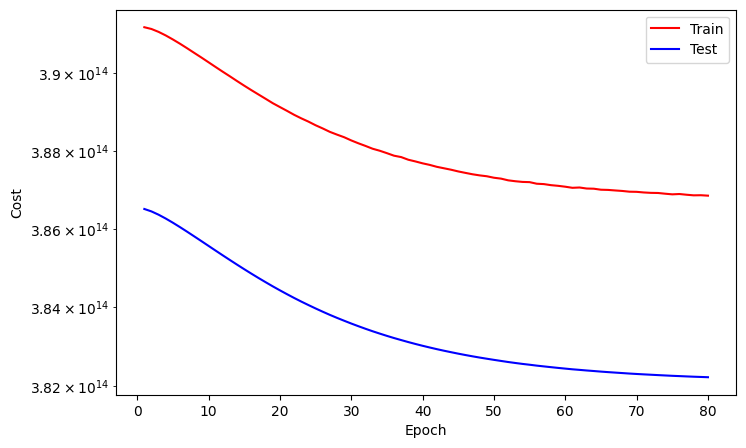

Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    81
Train_cost  = 386858230793784.3125 | Test_cost  = 382221145107222.5625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    82
Train_cost  = 386840284061639.4375 | Test_cost  = 382214795062758.6875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    83
Train_cost  = 386843039767206.0625 | Test_cost  = 382209453637030.3125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    84
Train_cost  = 386836882223305.7500 | Test_cost  = 382204582930661.9375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    85
Train_cost  = 386828064791281.8750 | Test_cost  = 382199591829374.5000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    86
Train_cost  = 386818662267527.8125 | Test_cost  = 382194289355894.7500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    87
Train_cost  = 386809914831935.6875 | Test_cost  = 382189630674726.6875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    88
Train_cost  = 386818840166388.4375 | Test_cost  = 382185834499317.8750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    89
Train_cost  = 386801421015563.8125 | Test_cost  = 382180824458777.0000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    90
Train_cost  = 386801171215349.9375 | Test_cost  = 382177159745590.0625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    91
Train_cost  = 386804025162903.2500 | Test_cost  = 382174083831022.1875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    92
Train_cost  = 386794037773810.3125 | Test_cost  = 382169582705295.9375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    93
Train_cost  = 386793474116489.6250 | Test_cost  = 382167065214096.3750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    94
Train_cost  = 386788802923426.3125 | Test_cost  = 382164156732101.4375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    95
Train_cost  = 386789922345634.1875 | Test_cost  = 382161334550488.5000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    96
Train_cost  = 386786154390446.0000 | Test_cost  = 382157926002346.5000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    97
Train_cost  = 386783213890246.0625 | Test_cost  = 382154995010583.1875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    98
Train_cost  = 386776053930733.1250 | Test_cost  = 382152702015513.0625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch    99
Train_cost  = 386768602357602.3750 | Test_cost  = 382149759484259.3125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   100
Train_cost  = 386778300531747.6250 | Test_cost  = 382148022752137.2500 | 


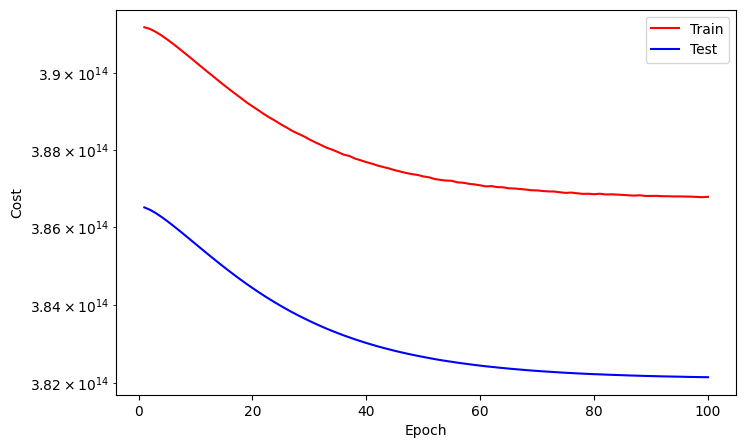

Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   101
Train_cost  = 386782102474745.5625 | Test_cost  = 382146805212997.0625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   102
Train_cost  = 386766513404742.3750 | Test_cost  = 382144468407966.8750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   103
Train_cost  = 386754326562250.3125 | Test_cost  = 382140918552813.5000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   104
Train_cost  = 386774054510261.1875 | Test_cost  = 382140361940575.8750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   105
Train_cost  = 386762123626905.7500 | Test_cost  = 382138305815539.4375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   106
Train_cost  = 386768142657032.6875 | Test_cost  = 382137415890553.7500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   107
Train_cost  = 386754994866815.7500 | Test_cost  = 382134725332870.8125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   108
Train_cost  = 386749769933989.9375 | Test_cost  = 382132748929930.6250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   109
Train_cost  = 386760482399591.1250 | Test_cost  = 382132430837149.4375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   110
Train_cost  = 386751190377993.2500 | Test_cost  = 382130377247696.1250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   111
Train_cost  = 386750057070449.3750 | Test_cost  = 382128507597979.2500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   112
Train_cost  = 386747006540819.8750 | Test_cost  = 382127562621085.9375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   113
Train_cost  = 386754516179019.3125 | Test_cost  = 382127059773559.4375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   114
Train_cost  = 386757877947162.3750 | Test_cost  = 382126210463181.6250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   115
Train_cost  = 386753245676162.1875 | Test_cost  = 382125548611308.6250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   116
Train_cost  = 386753861108106.2500 | Test_cost  = 382124225108080.6875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   117
Train_cost  = 386746974844953.0625 | Test_cost  = 382123237453184.0625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   118
Train_cost  = 386754423059945.5000 | Test_cost  = 382123143856532.2500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   119
Train_cost  = 386733945252581.1250 | Test_cost  = 382121206418777.3750 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   120
Train_cost  = 386747942041618.2500 | Test_cost  = 382120950570680.3125 | 


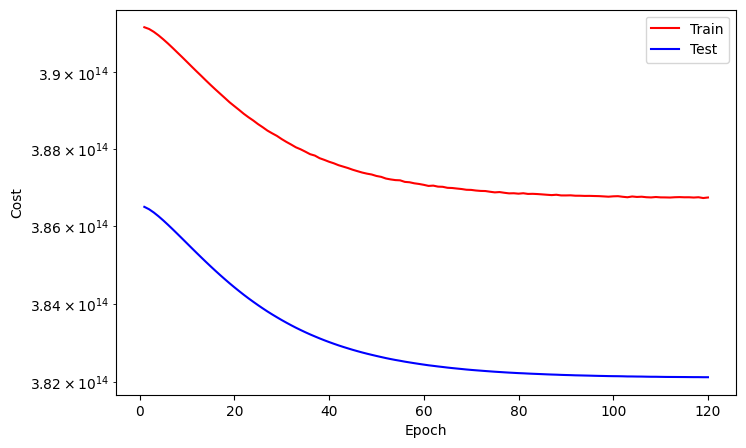

Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   121
Train_cost  = 386749462623905.2500 | Test_cost  = 382120367315415.1875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   122
Train_cost  = 386751424093640.8125 | Test_cost  = 382119450022949.6250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   123
Train_cost  = 386745006768902.3125 | Test_cost  = 382118415181627.5625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   124
Train_cost  = 386745365475213.3750 | Test_cost  = 382117849035080.0625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   125
Train_cost  = 386754654726212.3750 | Test_cost  = 382117417636663.1250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   126
Train_cost  = 386736817315215.4375 | Test_cost  = 382115702269416.0625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   127
Train_cost  = 386741091671196.2500 | Test_cost  = 382115051646553.9375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   128
Train_cost  = 386728904977475.6875 | Test_cost  = 382113834521386.5000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   129
Train_cost  = 386730677996896.6875 | Test_cost  = 382114182678938.8125 | 
==> EarlyStop patience =  1 | Best test_cost: 382113834521386.5000


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   130
Train_cost  = 386749875449607.1250 | Test_cost  = 382115124706276.2500 | 
==> EarlyStop patience =  2 | Best test_cost: 382113834521386.5000


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   131
Train_cost  = 386743039702988.1875 | Test_cost  = 382114323364991.0000 | 
==> EarlyStop patience =  3 | Best test_cost: 382113834521386.5000


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   132
Train_cost  = 386730063203160.6250 | Test_cost  = 382113649870134.4375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   133
Train_cost  = 386735341073291.1250 | Test_cost  = 382112409665986.0625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   134
Train_cost  = 386733221149016.5625 | Test_cost  = 382111972471950.6250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   135
Train_cost  = 386751656237485.6250 | Test_cost  = 382112859447380.5000 | 
==> EarlyStop patience =  1 | Best test_cost: 382111972471950.6250


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   136
Train_cost  = 386740923574542.0000 | Test_cost  = 382112772933543.7500 | 
==> EarlyStop patience =  2 | Best test_cost: 382111972471950.6250


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   137
Train_cost  = 386749764946911.9375 | Test_cost  = 382112933529098.0000 | 
==> EarlyStop patience =  3 | Best test_cost: 382111972471950.6250


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   138
Train_cost  = 386743839131805.5625 | Test_cost  = 382112705003202.5625 | 
==> EarlyStop patience =  4 | Best test_cost: 382111972471950.6250


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   139
Train_cost  = 386740914688142.5000 | Test_cost  = 382112034205637.1875 | 
==> EarlyStop patience =  5 | Best test_cost: 382111972471950.6250


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   140
Train_cost  = 386740629707791.1875 | Test_cost  = 382111794334301.0000 | 


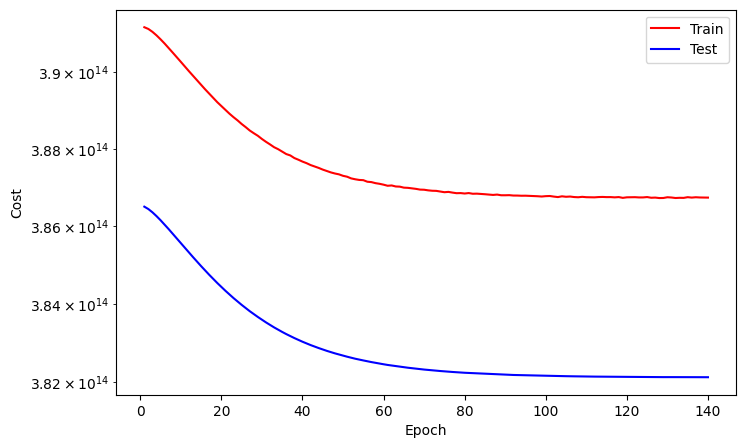

Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   141
Train_cost  = 386728642065968.5625 | Test_cost  = 382110683852395.3125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   142
Train_cost  = 386725545405328.6875 | Test_cost  = 382110246600145.0000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   143
Train_cost  = 386746278841406.1250 | Test_cost  = 382110965256841.4375 | 
==> EarlyStop patience =  1 | Best test_cost: 382110246600145.0000


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   144
Train_cost  = 386737514598412.5000 | Test_cost  = 382111215205826.7500 | 
==> EarlyStop patience =  2 | Best test_cost: 382110246600145.0000


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   145
Train_cost  = 386745044334773.4375 | Test_cost  = 382110937986386.4375 | 
==> EarlyStop patience =  3 | Best test_cost: 382110246600145.0000


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   146
Train_cost  = 386740815633842.1875 | Test_cost  = 382110897624043.1875 | 
==> EarlyStop patience =  4 | Best test_cost: 382110246600145.0000


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   147
Train_cost  = 386740733581532.1250 | Test_cost  = 382110626931142.0000 | 
==> EarlyStop patience =  5 | Best test_cost: 382110246600145.0000


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   148
Train_cost  = 386722992207901.2500 | Test_cost  = 382109237205210.5000 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   149
Train_cost  = 386728714626551.8750 | Test_cost  = 382109069934345.6250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   150
Train_cost  = 386747059356843.4375 | Test_cost  = 382109807323309.1250 | 
==> EarlyStop patience =  1 | Best test_cost: 382109069934345.6250


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   151
Train_cost  = 386723758743133.7500 | Test_cost  = 382108882741042.1250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   152
Train_cost  = 386748300769490.3750 | Test_cost  = 382109944639364.4375 | 
==> EarlyStop patience =  1 | Best test_cost: 382108882741042.1250


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   153
Train_cost  = 386729454961837.0000 | Test_cost  = 382108916428074.7500 | 
==> EarlyStop patience =  2 | Best test_cost: 382108882741042.1250


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   154
Train_cost  = 386730449472079.3125 | Test_cost  = 382108806945218.6875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   155
Train_cost  = 386733356784385.6250 | Test_cost  = 382108214634299.5625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   156
Train_cost  = 386724026506962.1250 | Test_cost  = 382107404903597.8125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   157
Train_cost  = 386733999357957.2500 | Test_cost  = 382107991477113.2500 | 
==> EarlyStop patience =  1 | Best test_cost: 382107404903597.8125


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   158
Train_cost  = 386727144357832.1875 | Test_cost  = 382107909419951.9375 | 
==> EarlyStop patience =  2 | Best test_cost: 382107404903597.8125


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   159
Train_cost  = 386716841720942.6875 | Test_cost  = 382106825167101.0625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   160
Train_cost  = 386736206267717.1250 | Test_cost  = 382107793882744.3750 | 


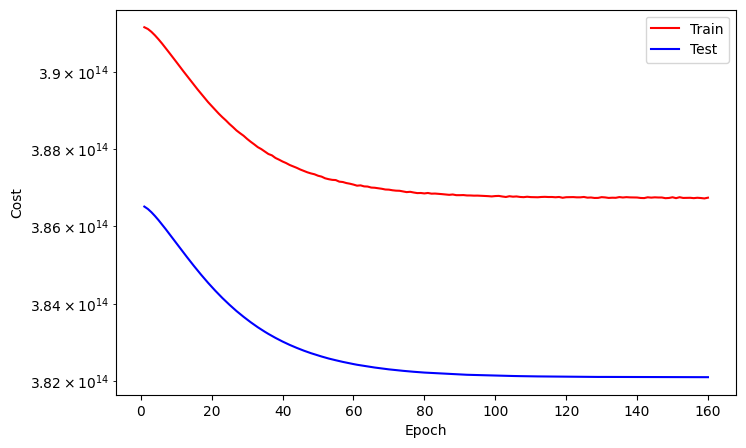

==> EarlyStop patience =  1 | Best test_cost: 382106825167101.0625


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   161
Train_cost  = 386743614177503.1875 | Test_cost  = 382107988424064.2500 | 
==> EarlyStop patience =  2 | Best test_cost: 382106825167101.0625


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   162
Train_cost  = 386726755481100.8125 | Test_cost  = 382106788847460.4375 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   163
Train_cost  = 386719595258542.6875 | Test_cost  = 382106214427926.2500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   164
Train_cost  = 386728924526907.6250 | Test_cost  = 382106189020348.6250 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   165
Train_cost  = 386725530229562.0000 | Test_cost  = 382106380107583.3125 | 
==> EarlyStop patience =  1 | Best test_cost: 382106189020348.6250


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   166
Train_cost  = 386715952548438.6875 | Test_cost  = 382105949362467.1875 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   167
Train_cost  = 386725078571275.5000 | Test_cost  = 382105364865283.7500 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   168
Train_cost  = 386731567758018.2500 | Test_cost  = 382105732945274.6875 | 
==> EarlyStop patience =  1 | Best test_cost: 382105364865283.7500


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   169
Train_cost  = 386728837651922.8125 | Test_cost  = 382105853657141.6875 | 
==> EarlyStop patience =  2 | Best test_cost: 382105364865283.7500


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   170
Train_cost  = 386723449228428.5625 | Test_cost  = 382105369418984.0625 | 
==> EarlyStop patience =  3 | Best test_cost: 382105364865283.7500


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   171
Train_cost  = 386739490904327.8125 | Test_cost  = 382106020151807.6250 | 
==> EarlyStop patience =  4 | Best test_cost: 382105364865283.7500


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   172
Train_cost  = 386744182655881.6250 | Test_cost  = 382106384240842.5000 | 
==> EarlyStop patience =  5 | Best test_cost: 382105364865283.7500


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   173
Train_cost  = 386726519815253.4375 | Test_cost  = 382105485939376.9375 | 
==> EarlyStop patience =  6 | Best test_cost: 382105364865283.7500


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   174
Train_cost  = 386721894821118.0000 | Test_cost  = 382104814255651.0625 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   175
Train_cost  = 386711461289063.0625 | Test_cost  = 382103632583368.8125 | 


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   176
Train_cost  = 386728203985772.6875 | Test_cost  = 382104463361997.6875 | 
==> EarlyStop patience =  1 | Best test_cost: 382103632583368.8125


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   177
Train_cost  = 386730209661114.1875 | Test_cost  = 382104609526720.5625 | 
==> EarlyStop patience =  2 | Best test_cost: 382103632583368.8125


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   178
Train_cost  = 386719948794506.5625 | Test_cost  = 382104300120898.8125 | 
==> EarlyStop patience =  3 | Best test_cost: 382103632583368.8125


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   179
Train_cost  = 386723466414766.0625 | Test_cost  = 382104611907063.8750 | 
==> EarlyStop patience =  4 | Best test_cost: 382103632583368.8125


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   180
Train_cost  = 386716612892114.0625 | Test_cost  = 382104037332289.8750 | 


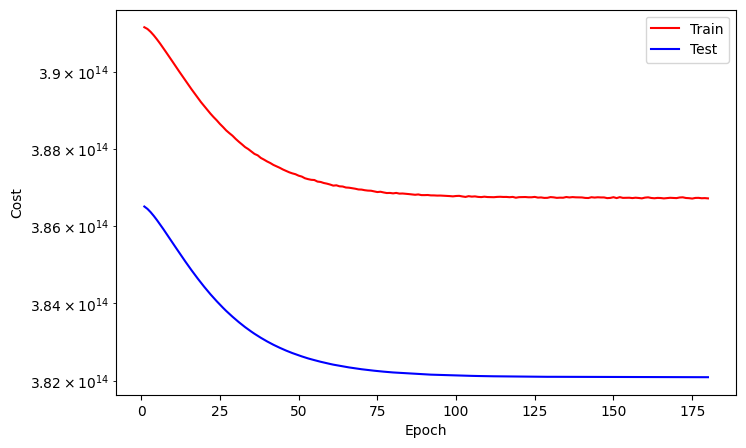

==> EarlyStop patience =  5 | Best test_cost: 382103632583368.8125


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   181
Train_cost  = 386716521339452.8125 | Test_cost  = 382103780856765.3750 | 
==> EarlyStop patience =  6 | Best test_cost: 382103632583368.8125


Train:   0%|          | 0/973 [00:00<?, ?it/s]

Test:   0%|          | 0/325 [00:00<?, ?it/s]


Epoch   182
Train_cost  = 386736158949769.1875 | Test_cost  = 382104361796370.4375 | 
==> EarlyStop patience =  7 | Best test_cost: 382103632583368.8125
==> Execute Early Stopping at epoch: 182 | Best test_cost: 382103632583368.8125
==> Best model is saved at model


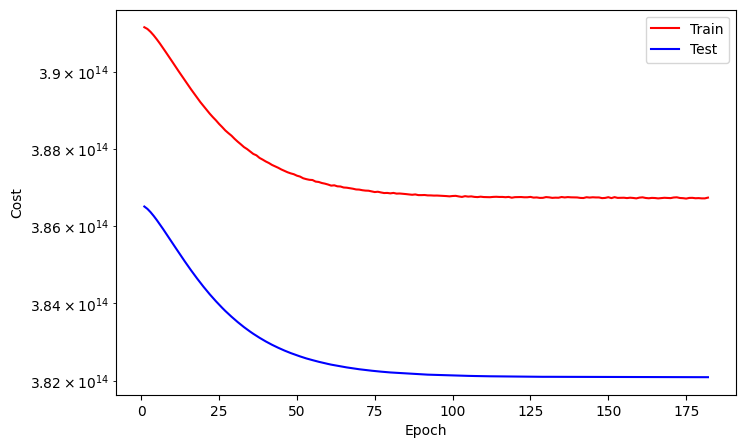

In [207]:
while True:
    train_cost= loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost= loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

#EVALUATION

In [208]:
with torch.no_grad():
    model.eval()
    output = model(X_test)

In [209]:
output = output.reshape(-1)
output

tensor([116327.7344, 139280.9531, 159905.1719,  ..., 146361.2656,
        161310.6250, 142855.1562])

In [210]:
y_test

tensor([14864700.,  9161320., 22984000.,  ..., 45277700., 17144700.,
         1470060.])

In [211]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test.numpy(), output.numpy())
mse

381822730000000.0

In [212]:
from sklearn.metrics import r2_score
test_r2 = r2_score(y_test.numpy(), output.numpy())
test_r2

-2.620690313511275